The conjunctiva is a thin membrane in our eyes. It covers the inside of our eyelids and protects our eyes with the mucus layer. This type of segmentation may help quick screening for some diseases like conjunctivitis.

I have used the following methods.

* Dice and Jaccard coefficients implementation,
* The project took place using Google TPU
* Custom layers for encoding and decoding
* Custom callback class  that used predicting a sample from the train dataset during training


## Result
In the 100th epoch
* loss: 0.0024 - dice_coef: 0.9102 - jaccard: 0.8283


## References
1. [Dataset] Rahman, Mohammad Marufur; Faruk, Omar; Ullah, Syed Shah Asheq; Alam, Md. Johurul; Sadman, Shah Md. Safi (2023), “Eye Conjunctiva Segmentation Dataset”, Mendeley Data, V1, doi: 10.17632/yxwjgcndg2.1
2. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation https://doi.org/10.48550/ARXIV.1505.04597
3. https://en.wikipedia.org/wiki/Conjunctiva


In [18]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2

from tensorflow.keras.layers import Layer, Conv2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.layers import Add, Multiply, Input, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from keras import backend as K

In [2]:
images_data = np.load('/content/drive/MyDrive/Colab Notebooks/new_eye_dataset/images.npy')
masks_data = np.load('/content/drive/MyDrive/Colab Notebooks/new_eye_dataset/masks.npy')

In [3]:
# Functions for plotting random samples

def create_random_image_and_mask(images, masks , cmap2 = 'gray' ):

  idx = random.randint(0, images.shape[0]-1)

  img = images[idx] / 255.0
  mask = masks[idx] / 255.0

  fig, axs = plt.subplots(1,2 ,figsize =(6,3), dpi = 200)
  fig.suptitle('no :' + str(idx), color='red')

  axs[0].imshow(img, cmap = 'gray')
  axs[0].set_title('original image' )
  axs[0].axis('off')

  axs[1].imshow(mask, cmap = 'gray')
  axs[1].set_title('mask' )
  axs[1].axis('off')



def create_random_image_and_mask_test(images, masks , preds , cmap = 'gray'  ,cmap2 = 'gray' ):

  idx = random.randint(0, images.shape[0]-1)
  img = images[idx] / 255.0
  mask = masks[idx] / 255.0
  pred = preds[idx]

  fig, axs = plt.subplots(1,3 ,figsize =(8,4), dpi = 200)
  fig.suptitle('no :' + str(idx), color='red')

  axs[0].imshow(img, cmap = 'gray')
  axs[0].set_title('original image' )
  axs[0].axis('off')

  axs[1].imshow(mask, cmap = cmap )
  axs[1].set_title('original mask' )
  axs[1].axis('off')

  axs[2].imshow(pred, cmap = cmap2 )
  axs[2].set_title('pred mask' )
  axs[2].axis('off')


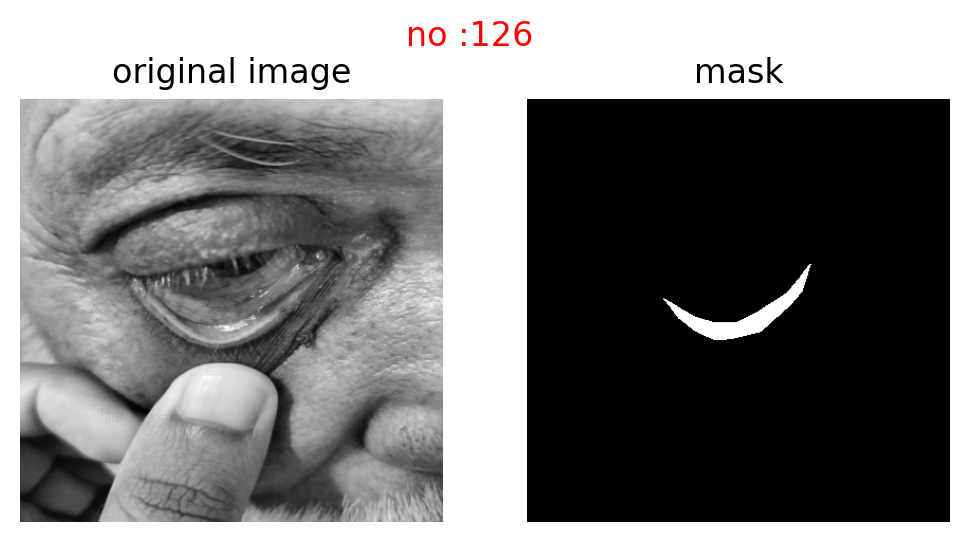

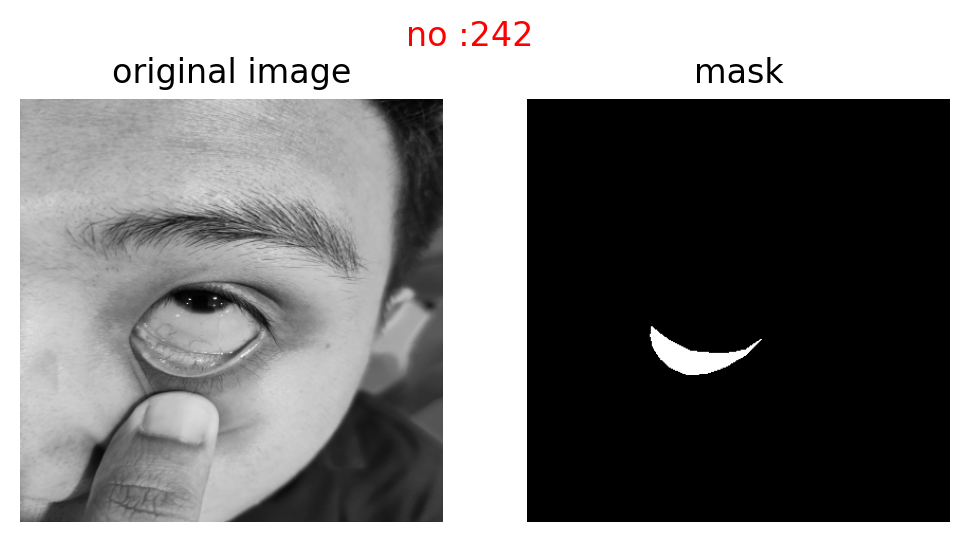

In [4]:
create_random_image_and_mask(images_data, masks_data )
create_random_image_and_mask(images_data, masks_data )

In [5]:
# Train, test split

X_train = images_data[:500]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2] ,1  ) / 255.0

y_train = masks_data[:500]
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2] ,1  ) / 255.0

X_test = images_data[500:]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] ,1  ) / 255.0


y_test = masks_data[500:]
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2] ,1  )  / 255.0


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(500, 400, 400, 1)
(500, 400, 400, 1)
(47, 400, 400, 1)
(47, 400, 400, 1)


In [6]:
# Creating Dice metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def jaccard(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)

  jac = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-2 )

  return jac

In [7]:
# Connecting TPU and creating strategy and the model

tpu  = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

print('total tpu core : ' + str(strategy.num_replicas_in_sync))

total tpu core : 8


In [12]:
# Encoding block for U-net architecture

class EncoderBlock(Layer):

  def __init__(self, filters, kernel_size, rate, pooling = True, **kwargs):
    super(EncoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.kernel_size = kernel_size
    self.rate = rate
    self.pooling = pooling

    self.c1 = Conv2D(filters, kernel_size, strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'lecun_normal')
    self.drop = Dropout(rate)
    self.c2 = Conv2D(filters, kernel_size, strides = 1, padding = 'same', activation = 'relu', kernel_initializer = 'lecun_normal')
    self.pool = MaxPool2D()


  def call(self, inputs):
    L = self.c1(inputs)
    L = self.drop(L)
    L = self.c2(L)
    if self.pooling:
      P = self.pool(L)
      return P, L
    else:
      return L


  def get_config(self):
    base_config = super().get_config()

    return {
          **base_config,
          "filters" : self.filters,
          "kernel_size": self.kernel_size,
          "rate" : self.rate,
          "pooling" : self.pooling
      }



In [13]:
# Decoding block for U-net architecture

class DecoderBlock(Layer):

  def __init__(self, filters, kernel_size, rate, **kwargs ):
    super(DecoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.kernel_size = kernel_size
    self.rate = rate

    self.up = UpSampling2D()
    self.net = EncoderBlock(filters, kernel_size, rate, pooling = False)


  def call(self, inputs):
    inputs, skip_inputs = inputs
    L = self.up(inputs)
    C_ = concatenate([L, skip_inputs ])
    L = self.net(C_)
    return L


  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters" : self.filters,
        "kernel_size": self.kernel_size,
        "rate" : self.rate
    }

In [14]:
# Custom callback for predicting one sample from train dataset during training

class PredictDuringTraining(Callback):

  def on_epoch_end(self, epochs, logs = None):

    sample_idx = np.random.permutation(X_train.shape[0])[0]

    img = X_train[sample_idx]
    mask = y_train[sample_idx]
    pred = self.model.predict(img[np.newaxis,...], verbose = 0)
    pred_ = np.squeeze(pred)
    threshold  = 0.85
    bitmap_pred = (pred_ > threshold).astype(np.uint8)

    fig, axs = plt.subplots(1,3 ,figsize =(6,3), dpi = 150)
    fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(sample_idx) , color='red', fontsize = 8 )

    axs[0].imshow(img, cmap = 'gray')
    axs[0].axis('off')
    axs[0].set_title('original image')

    axs[1].imshow(mask, cmap = 'gray')
    axs[1].axis('off')
    axs[1].set_title('original mask')

    axs[2].imshow(bitmap_pred, cmap = 'gray')
    axs[2].axis('off')
    axs[2].set_title('pred mask')


    plt.tight_layout()
    plt.show()


#Base U-net Model

In [15]:
# Creating model

with strategy.scope():
  inp = Input(shape = (400, 400, 1))

  p1, c1 = EncoderBlock(32, 2, 0.1, name = 'Encoder1')(inp)
  p2, c2 = EncoderBlock(64, 2, 0.1, name = 'Encoder2')(p1)
  p3, c3 = EncoderBlock(128, 2, 0.2, name = 'Encoder3')(p2)
  p4, c4 = EncoderBlock(256, 2, 0.2, name = 'Encoder4')(p3)

  encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'Encoding')(p4)

  d1 = DecoderBlock(256, 2, 0.2 ,name = 'Decoder1' )([encoding, c4])
  d2 = DecoderBlock(128 ,2, 0.2 ,name = 'Decoder2' )([d1, c3])
  d3 = DecoderBlock(64 ,2, 0.1 ,name = 'Decoder3' )([d2, c2])
  d4 = DecoderBlock(32 ,2, 0.1 ,name = 'Decoder4' )([d3, c1])

  out = Conv2D(1, kernel_size = 1 ,activation ='sigmoid', padding = 'same')(d4)
  model = Model(inputs = inp, outputs = out)

  model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = [ dice_coef, jaccard ])
  my_callbacks  = [PredictDuringTraining()]

#Training

In [ ]:
BATCH_SIZE = 8
SPE = len(X_train) // BATCH_SIZE

hist = model.fit(X_train, y_train, epochs = 100 , steps_per_epoch=SPE,batch_size = BATCH_SIZE, callbacks = my_callbacks, verbose = 2)

#Prediction

In [ ]:
pred = model.predict(X_test, verbose=1)

threshold  = 0.8
bitmap_preds = (pred > threshold).astype(np.uint8)

2/2 [==============================] - 7s 7s/step


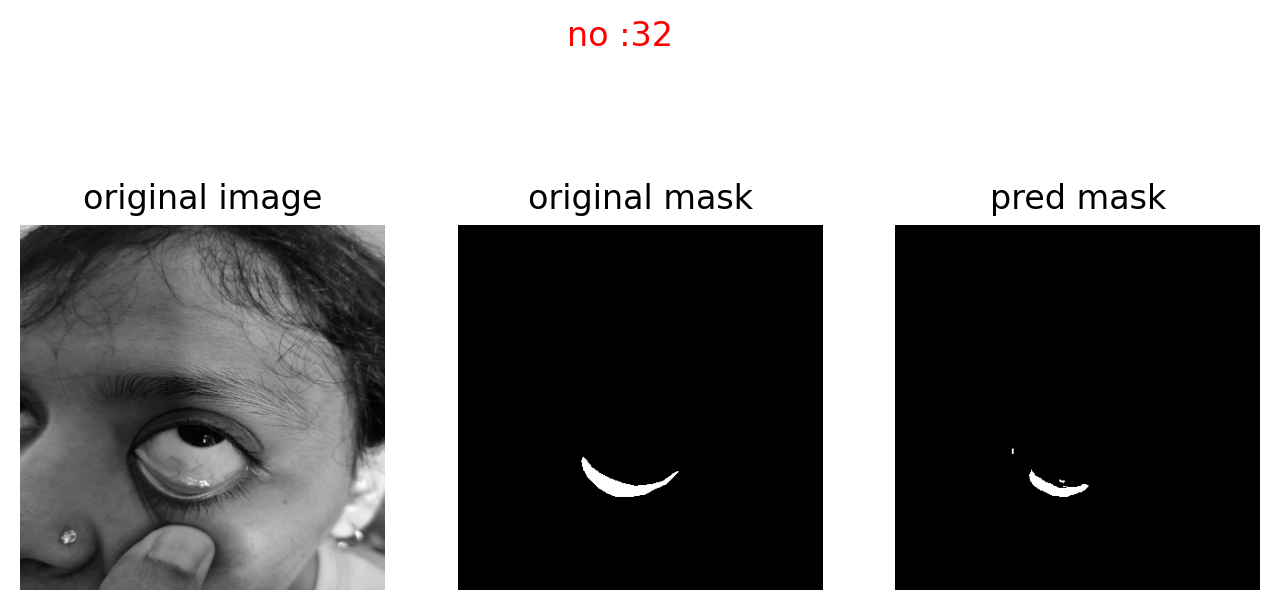

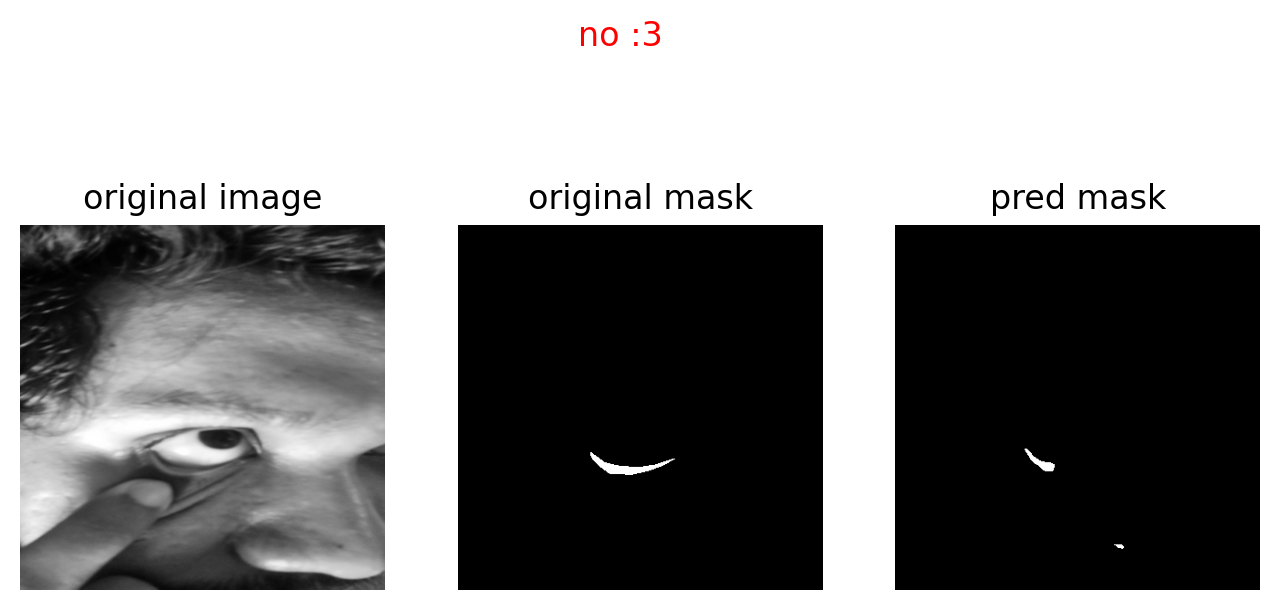

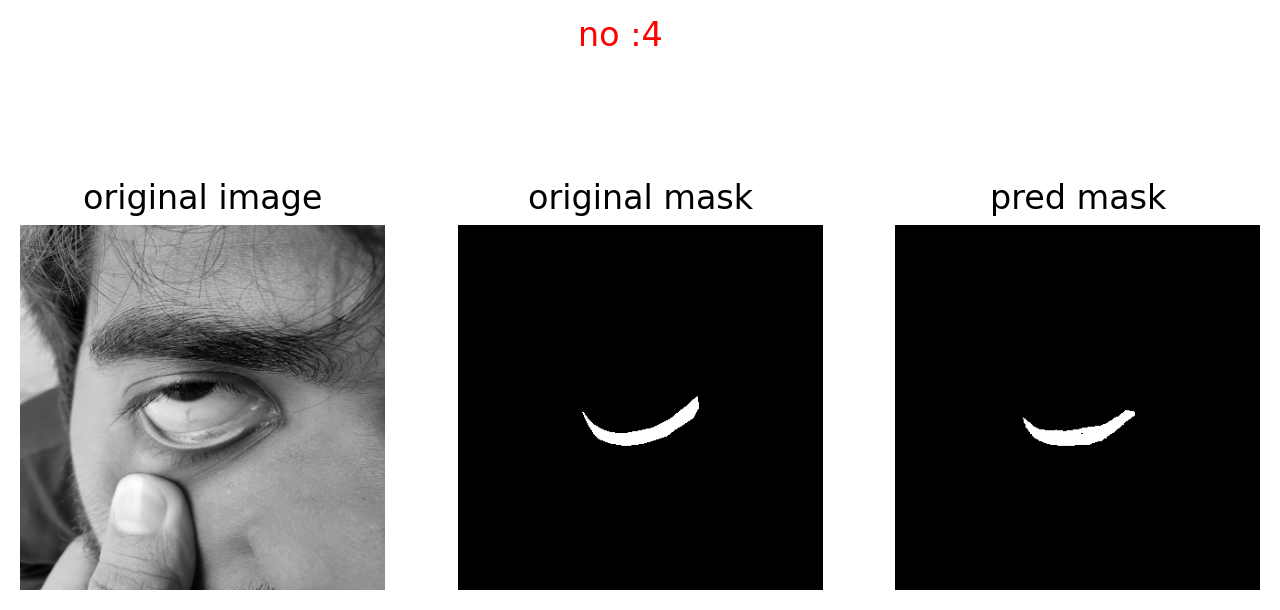

In [ ]:
create_random_image_and_mask_test(X_test, y_test, bitmap_preds)
create_random_image_and_mask_test(X_test, y_test, bitmap_preds)
create_random_image_and_mask_test(X_test, y_test, bitmap_preds)